In [316]:
from langchain_groq import ChatGroq
import os

groq_api_key = os.getenv('GROQ_API_KEY')

llm = ChatGroq(groq_api_key=groq_api_key, model="llama-3.3-70b-versatile")
# qwen-qwq-32b
# llama-3.3-70b-versatile

In [317]:
llm.invoke("hi").content

"It's nice to meet you. Is there something I can help you with or would you like to chat?"

In [318]:
import operator, json
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults

In [319]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [320]:
tavily = TavilySearchResults()

In [321]:
tools = [tavily]

In [322]:
llm_with_tool = llm.bind_tools(tools)

In [323]:
memory = MemorySaver()

In [324]:
def ai_assistant(state: AgentState):
    return {"messages": [llm_with_tool.invoke(state["messages"])]}

In [325]:
graph_builder = StateGraph(AgentState)

graph_builder.add_node("ai_assistant", ai_assistant)
graph_builder.add_node("tools", ToolNode(tools))

graph_builder.add_edge(START, "ai_assistant")
graph_builder.add_conditional_edges(
    "ai_assistant",
    tools_condition
)

graph_builder.add_edge("tools", "ai_assistant")

app = graph_builder.compile(checkpointer=memory,
                             interrupt_before=["tools"]
                             # Note: can also interrupt __after__ tools, if desired.
                             # interrupt_after=["tools"]
                             )

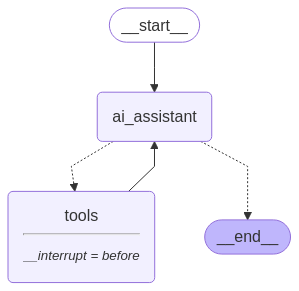

In [326]:
from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

In [327]:
user_input = "What is the current capital of India?"
config = {"configurable": {"thread_id": 1}}

In [328]:
events = app.stream(
    {"messages": [("user", user_input)]}, config=config, stream_mode="values"
)

In [329]:
for event in events:
    print(event)

{'messages': [('user', 'What is the current capital of India?')]}
{'messages': [('user', 'What is the current capital of India?'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_m91b', 'function': {'arguments': '{"query": "current capital of India"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 286, 'total_tokens': 307, 'completion_time': 0.076363636, 'prompt_time': 0.026360109, 'queue_time': 0.057856281, 'total_time': 0.102723745}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1996302c-858b-439c-8a6f-b10ef87bf285-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current capital of India'}, 'id': 'call_m91b', 'type': 'tool_call'}], usage_metadata={'input_tokens': 286, 'output_tokens': 21, 'total_tokens': 307})]}


In [330]:
# for event in events:
#     if "messages" in event:
#         event["messages"][-1].pretty_print()

In [331]:
snapshot = app.get_state(config)

In [332]:
snapshot

StateSnapshot(values={'messages': [['user', 'What is the current capital of India?'], AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_m91b', 'function': {'arguments': '{"query": "current capital of India"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 286, 'total_tokens': 307, 'completion_time': 0.076363636, 'prompt_time': 0.026360109, 'queue_time': 0.057856281, 'total_time': 0.102723745}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1996302c-858b-439c-8a6f-b10ef87bf285-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current capital of India'}, 'id': 'call_m91b', 'type': 'tool_call'}], usage_metadata={'input_tokens': 286, 'output_tokens': 21, 'total_tokens': 307})]}, next=('tools',), config={'configurable': {'thread_id': 1, 'checkpoint_ns': '', 'checkpoin

In [333]:
snapshot.next

('tools',)

In [334]:
last_message = snapshot.values['messages'][-1]

last_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'current capital of India'},
  'id': 'call_m91b',
  'type': 'tool_call'}]

In [335]:
events = app.stream(None, config, stream_mode="values")

In [336]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_m91b)
 Call ID: call_m91b
  Args:
    query: current capital of India
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://en.wikipedia.org/wiki/List_of_capitals_of_India", "content": "The current capital city is New Delhi, which replaced Calcutta in 1911."}, {"url": "https://pwonlyias.com/states-and-capitals-of-india/", "content": "The capital of India is New Delhi. India follows a parliamentary form of government. Understanding the rich history of States and Capitals of India. States and"}, {"url": "https://currentaffairs.adda247.com/states-and-capitals/", "content": "What is the official capital of Republic of India?\n\nNew Delhi is the official capital of the Republic of India.\n\nWhat is the capital of Arunachal Pradesh?\n\nItanagar, the charming capital of Arunachal Pradesh, 

In [337]:
user_input = "what is the weather there?"

config = {"configurable": {"thread_id": "1"}}

In [338]:
events = app.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

In [339]:
for event in events:
    print(event)

{'messages': [('user', 'what is the weather there?')]}
{'messages': [('user', 'what is the weather there?'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_2dzn', 'function': {'arguments': '{"query": "current weather"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 284, 'total_tokens': 303, 'completion_time': 0.069090909, 'prompt_time': 0.017976653, 'queue_time': 0.05258391700000001, 'total_time': 0.087067562}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_6507bcfb6f', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-2d18f678-4ff5-4a3a-be8f-e18e1788617a-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather'}, 'id': 'call_2dzn', 'type': 'tool_call'}], usage_metadata={'input_tokens': 284, 'output_tokens': 19, 'total_tokens': 303})]}


In [340]:
# for event in events:
#     if "messages" in event:
#         event["messages"][-1].pretty_print()

In [341]:
snapshot = app.get_state(config)

In [342]:
snapshot.next

('tools',)

In [343]:
last_message = snapshot.values['messages'][-1]

In [344]:
last_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'current weather'},
  'id': 'call_2dzn',
  'type': 'tool_call'}]

In [345]:
events = app.stream(None, config, stream_mode="values")

In [346]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_2dzn)
 Call ID: call_2dzn
  Args:
    query: current weather
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.weather25.com/north-america/usa?page=date&date=8-5", "content": "| 00:00 | 03:00 | 06:00 | 09:00 | 12:00 | 15:00 | 18:00 | 21:00\nTemperature | 19°C | 17°C | 16°C | 17°C | 17°C | 17°C | 16°C | 13°C\nWeather | Partly cloudy | Clear | Cloudy | Cloudy | Cloudy | Cloudy | Overcast | Mist\nChance of rain | 0% | 0% | 0% | 0% | 0% | 0% | 0% | 0%\nPrecipitation | 0mm | 0mm | 0mm | 0mm | 0mm | 0mm | 0mm | 0mm\nHumidity | 69% | 77% | 87% | 80% | 75% | 69% | 75% | 95%\nWind | 6Km/h | 7Km/h | 5Km/h | 5Km/h | 3Km/h | 5Km/h | 6Km/h | 11Km/h [...] Wind Gust | 13Km/h | 14Km/h | 10Km/h | 6Km/h | 3Km/h | 7Km/h | 10Km/h | 17Km/h\nWind Degree | 284° | 342° | 8° | 19° | 241° | 122° | 33

In [347]:
snapshot = app.get_state(config)

In [348]:
snapshot.next

()

In [349]:
user_input = "what is the latest news there?"

config = {"configurable": {"thread_id": "1"}}

In [350]:
events = app.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

In [351]:
# for event in events:
#     if 'messages' in event:
#         event['messages'][-1].pretty_print()

In [352]:
for event in events:
    print(event)

{'messages': [['user', 'what is the weather there?'], AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_2dzn', 'function': {'arguments': '{"query": "current weather"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 284, 'total_tokens': 303, 'completion_time': 0.069090909, 'prompt_time': 0.017976653, 'queue_time': 0.05258391700000001, 'total_time': 0.087067562}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_6507bcfb6f', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-2d18f678-4ff5-4a3a-be8f-e18e1788617a-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather'}, 'id': 'call_2dzn', 'type': 'tool_call'}], usage_metadata={'input_tokens': 284, 'output_tokens': 19, 'total_tokens': 303}), ToolMessage(content='[{"url": "https://www.weather25.com/north-america/usa?page=date&date=8-5", "content": "| 00:00 | 03:00 | 06:00 |

In [353]:
snapshot = app.get_state(config)

In [354]:
snapshot.next

('tools',)

In [355]:
current_message = snapshot.values['messages'][-1]

In [356]:
current_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_p575)
 Call ID: call_p575
  Args:
    query: latest news


In [360]:
tool_call_id = current_message.tool_calls[0]["id"]

In [361]:
tool_call_id

'call_p575'

In [362]:
from langchain_core.messages import AIMessage, ToolMessage

In [363]:
answer = "it is just related to raining which is happing on daily basis in delhi"

In [364]:
new_message = [
    ToolMessage(content=answer, tool_call_id=tool_call_id),
    AIMessage(content=answer)
]

In [365]:
app.update_state(
    config,
    {"messages": new_message}
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f02bceb-1ab0-6469-8007-8170cac40037'}}

In [366]:
print(app.get_state(config).values['messages'][-1])

content='it is just related to raining which is happing on daily basis in delhi' additional_kwargs={} response_metadata={}
